In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Preparing dataset
X, y = make_blobs(n_samples=100, centers=2, n_features=2)
y = y.astype(int)

# Shuffling dataset
shuff_idx = np.arange(y.shape[0])
shuff_gen = np.random.RandomState(50)
shuff_gen.shuffle(shuff_idx)

X, y = X[shuff_idx], y[shuff_idx]

X_train, X_test = X[shuff_idx[:70]], X[shuff_idx[70:]]
y_train, y_test = y[shuff_idx[:70]], y[shuff_idx[70:]]

# Normalize
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 3080


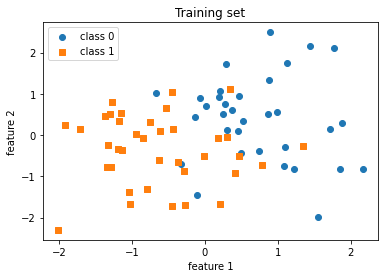

In [4]:
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')
plt.title("Training set")
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()
plt.show()

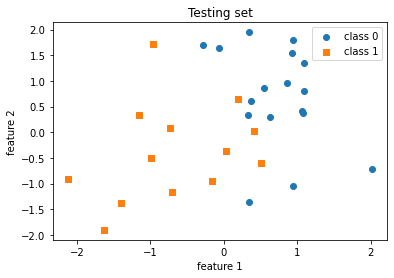

In [5]:
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')
plt.title("Testing set")
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()
plt.show()